# Mounting and Installation of Package

In [138]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My\ Drive/Colab\ Notebooks/adversarial_reisz

/content/drive/My Drive/Colab Notebooks/adversarial_reisz


In [4]:
!python setup.py develop

running develop
running egg_info
writing advreisz.egg-info/PKG-INFO
writing dependency_links to advreisz.egg-info/dependency_links.txt
writing top-level names to advreisz.egg-info/top_level.txt
writing manifest file 'advreisz.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.6/dist-packages/advreisz.egg-link (link to .)
Adding advreisz 0.0.1 to easy-install.pth file

Installed /content/drive/My Drive/Colab Notebooks/adversarial_reisz
Processing dependencies for advreisz==0.0.1
Finished processing dependencies for advreisz==0.0.1


In [139]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
import scipy.special

# Data Generation

In [293]:
def true_propensity(X):
    return .5 + .3* scipy.special.expit(10*X[:, 1])

def true_reisz(X):
    return (X[:, 0]==1)/true_propensity(X) - (X[:, 0]==0)/(1 - true_propensity(X))

def true_f(X):
    return X[:, 0] + scipy.special.expit(10*X[:, 1])

def gen_data(n, p):
    X = np.random.uniform(-1, 1, size=(n, p))
    X[:, 0] = np.random.binomial(1, true_propensity(X))
    y = true_f(X) + np.random.normal(size=(n,))
    return X, y

np.random.seed(123)
n = 1000
p = 3
X, y = gen_data(n, p)
X_test, y_test = gen_data(n, p)

# Adversarial Reisz Estimator for ATE Moment

In [294]:
from advreisz.linear import SparseLinearAdvRiesz

In [295]:
class SeparateFeaturizer:
    
    def __init__(self, featurizer):
        self.featurizer = featurizer
    def transform(self, X):
        T = X[:, [0]]
        feats = self.featurizer.transform(X[:, 1:])
        return np.hstack([T * feats, (1 - T) * feats])
    def fit_transform(self, X):
        T = X[:, [0]]
        feats = self.featurizer.fit_transform(X[:, 1:])
        return np.hstack([T * feats, (1 - T) * feats])
    def get_feature_names(self):
        return ['T0 * {}'.format(i) for i in self.featurizer.get_feature_names()] +\
                ['T1 * {}'.format(i) for i in self.featurizer.get_feature_names()]

In [346]:
def moment_fn(x, test_fn):
    t1 = np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]])
    t0 = np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]])
    return test_fn(t1) - test_fn(t0) 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.pipeline import Pipeline

feat = SeparateFeaturizer(PolynomialFeatures(degree=3, include_bias=True))
feat = PolynomialFeatures(degree=3, include_bias=True)
# feat = Pipeline([('nys', Nystroem(n_components=50, kernel='rbf', gamma=1, degree=3)),
#                  ('p', PolynomialFeatures(degree=1, include_bias=True))])
# feat = Pipeline([('nys', RBFSampler(n_components=50, gamma=1)),
#                  ('p', PolynomialFeatures(degree=1, include_bias=True))])
splin = SparseLinearAdvRiesz(moment_fn, featurizer=feat,
                             n_iter=50000, lambda_theta=0.0001, B=100, eta_theta=1, eta_w=1,
                             tol=0.0001).fit(X)

gap increased  46300 0.011360604664694771 0.012005435896788225


In [347]:
coefs = splin.coef
print("Maximum violation: ", splin.max_violation_)
#print("Estimated non-zero coefs: ", np.array(list(zip(splin.get_feature_names(), coefs))))
print("Min/Max: ", splin.min_response_loss_, splin.max_response_loss_)
print("Dualit Gap: ", splin.duality_gap_)
print("Iters: ", splin.n_iters_)

Maximum violation:  0.0014439139401620227
Min/Max:  -0.0032641591474673825 0.0036917935486754415
Dualit Gap:  0.0069559526961428236
Iters:  50000


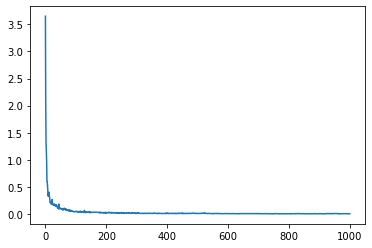

In [348]:
plt.plot(splin.duality_gaps)
plt.show()

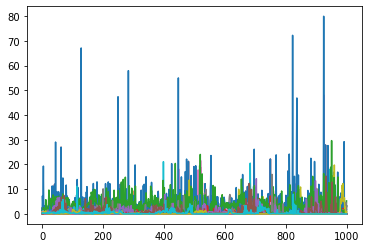

In [349]:
plt.plot(np.exp(np.array(splin.log_theta_list)))
plt.show()

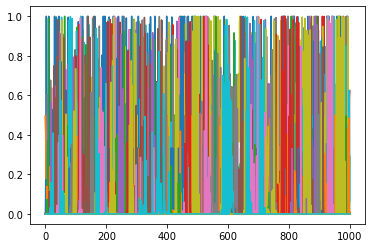

In [350]:
plt.plot(np.exp(np.array(splin.log_w_list)))
plt.show()

# Evaluation of Learned Reisz Representer

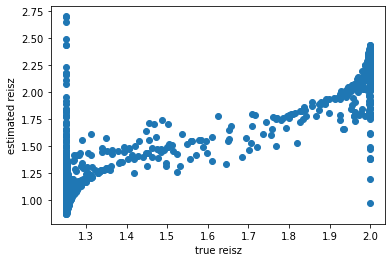

In [351]:
plt.figure()
treated = (X_test[:, 0] == 1)
plt.scatter(true_reisz(X_test[treated]), splin.predict(X_test[treated]))
plt.xlabel('true reisz')
plt.ylabel('estimated reisz')
plt.show()

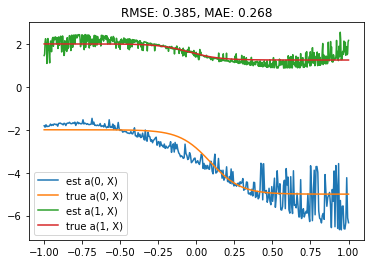

In [352]:
plt.figure()
error = true_reisz(X_test) - splin.predict(X_test)
plt.title("RMSE: {:.3f}, MAE: {:.3f}".format(np.sqrt(np.mean(error**2)), np.mean(np.abs(error))))
for t in [0, 1]:
    treated = (X_test[:, 0]==t) 
    Xtreated = X_test[treated].copy()
    Xtreated[:, 1] = np.linspace(-1, 1, Xtreated.shape[0])
    plt.plot(Xtreated[:, 1], splin.predict(Xtreated), label='est a({}, X)'.format(t))
    plt.plot(Xtreated[:, 1], true_reisz(Xtreated), label='true a({}, X)'.format(t))
plt.legend()
plt.show()

# Debiasing ATE

Applying the learned Reisz representer in order to debias a preliminary regression based model of the ATE

In [329]:
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV
from sklearn.pipeline import Pipeline

est = Lasso(alpha=0.1).fit(X, y)
propensity = Pipeline([('p', PolynomialFeatures(degree=3)), ('l', LogisticRegressionCV())]).fit(X[:, 1:], X[:, 0])

In [330]:
t1 = np.hstack([np.ones((X_test.shape[0], 1)), X_test[:, 1:]])
t0 = np.hstack([np.zeros((X_test.shape[0], 1)), X_test[:, 1:]])
a_test = splin.predict(X_test)
prop_test = propensity.predict_proba(X_test[:, 1:])[:, 1]
invp_test = (X_test[:, 0]==1)/prop_test - (X_test[:, 0]==0)/(1 - prop_test)
naive_ate = np.mean(y_test[X_test[:, 0]==1]) - np.mean(y_test[X_test[:, 0]==0])
biased_ate = np.mean(est.predict(t1) - est.predict(t0))
ips_ate = np.mean(invp_test * y_test)
reisz_ate = np.mean(a_test * y_test)
dr_ate = np.mean(est.predict(t1) - est.predict(t0) + invp_test * (y_test - est.predict(X_test)))
dr_reisz_ate = np.mean(est.predict(t1) - est.predict(t0) + a_test * (y_test - est.predict(X_test)))

In [331]:
print("True ATE: {:.3f}".format(np.mean(true_f(t1) - true_f(t0))))
print("Mean of Treated - Mean of Untreated: {:.3f}".format(naive_ate))
print("Lasso Regression based Estimate: {:.3f}".format(biased_ate))
print("IPS estimate with explicit propensity based reisz estimate (i.e. mean(a(X) Y)): {:.3f}".format(ips_ate))
print("IPS estimate with adversarial reisz: {:.3f}".format(reisz_ate))
print("DR estimate with explict propensity based reisz estimate: {:.3f}".format(dr_ate))
print("DR estimate with adversarial reisz: {:.3f}".format(dr_reisz_ate))

True ATE: 1.000
Mean of Treated - Mean of Untreated: 1.120
Lasso Regression based Estimate: 0.872
IPS estimate with explicit propensity based reisz estimate (i.e. mean(a(X) Y)): 0.895
IPS estimate with adversarial reisz: 0.774
DR estimate with explict propensity based reisz estimate: 0.855
DR estimate with adversarial reisz: 0.780


In [332]:
dr_reisz_ate = []
reisz_ate = []
biased_ate = []
for exp in range(1000):
    Xboot, yboot = gen_data(n, p)
    t1 = np.hstack([np.ones((Xboot.shape[0], 1)), Xboot[:, 1:]])
    t0 = np.hstack([np.zeros((Xboot.shape[0], 1)), Xboot[:, 1:]])
    aboot = splin.predict(Xboot)
    dr_reisz_ate.append(np.mean(est.predict(t1) - est.predict(t0) + aboot * (yboot - est.predict(Xboot))))
    reisz_ate.append(np.mean(aboot * yboot))

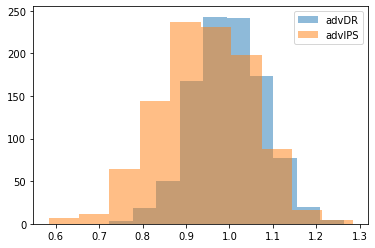

In [333]:
plt.hist(np.array(dr_reisz_ate), alpha=.5, label='advDR')
plt.hist(np.array(reisz_ate), alpha=.5, label='advIPS')
plt.legend()
plt.show()